# 2D Transient Stokes/Navier-Stokes Flow in Open/Closed Rectangular Channel

## Import Packages 

In [2]:
using Ferrite, SparseArrays, BlockArrays, LinearAlgebra, UnPack, LinearSolve, WriteVTK
using OrdinaryDiffEq
using FerriteGmsh
using FerriteGmsh: Gmsh
using Plots # added for simple plotting functionality 

## Section 1: Introduction 

### To do 
1. rewrite code for assemble in agreement with proper coding style; 

### Problem to Solve

<b>Computational Domain</b> Let $L = 1 \, \text{m}$ and $H = 0.1 \, \text{m}$. We consider a two-dimensional <b>rectangular open channel</b> $(x,y) \in \Omega = (0,L) \times (0,H)$. The mesh on $\Omega$ is generated using Ferrite in built meshing tools.  

<b>Governing Equations</b> We consider solving viscous, incompressible, laminar flow (linear) Stokes and (non-linear) Navier-Stokes flow in the channel. In the Stokes case, we consider both the stationary and the transient case. In the Navier-Stokes, we consider the transient formulation as a manner to avoid solving the non-linear equations in a stationary formulation. In both the Stokes and Navier-Stokes, transient simulations are carried out starting from rest (ramping to obtain suitable initial guess for simulations) until reaching
a steady-state simulatation. 

<b>Conservation of mass</b>

$$\nabla \cdot \mathbf{u} = 0 \quad \text{in } \Omega$$

<b>Conservation of momentum</b> (no body forces. Flow driven by the boundary conditions only)

$$\frac{\partial \mathbf{u}}{\partial t} + (\mathbf{u} \cdot \nabla) \mathbf{u} 
   = \nu \nabla^2 \mathbf{u} - \nabla p \quad \text{in } \Omega$$

where the non-linear convective term is dropped in case of the Stokes equations  
- $\mathbf{u} = (u_x, u_y)^T$ is the velocity vector 
- $p$ is the kinematic pressure field (divided by density) (units m$^2$/s$^2$)
- $\nu = \mu/\rho$ is the kinematic viscosity (units kg/(m s)) 

<b>Boundary conditions</b>
1. left patch ($x = 0$): inlet: prescribed parabolic or constant velocity profile (develops to a parabolic profile as flow enters the channel) or prescribed total pressure; 
2. bottom and top path ($y=0$ and $y=H$): wall: no-slip boundary condition $\mathbf{u} = (0, 0)$; 
3. right path ($x = L$): outlet (in case of open channel) or wall (in case of close channel). In case of outlet, either fix pressure at $p = p_{outlet}$ or do-nothing;  

Boundary conditions by integrating the pressure over the boundary not considered here. 

In case of a parabolic inlet profile, we set on the left boundary, 
$$\mathbf{u}(0, y, t) = \begin{pmatrix} u_{\text{in}}(y, t) \\ 0 \end{pmatrix}$$

where the parabolic profile is:
$$u_{\text{in}}(y, t) = v_{\text{in}}(t) \frac{y(H-y)}{H^2/4}$$

with $v_{\text{in}}(t)$ being the time-dependent inlet velocity amplitude. In transient simulations, $v_{\text{in}}(t)$ is ramped to a maximum velocity of $v_{max} = 1.5 \, \text{m/s}$ by setting $v_{\text{in}}(t) = \min(t * v_{max}, v_{max})$. The viscosity $\nu$ is varried to create various scenarios. 

### Closed-Form Solution in Case of Stationary Stokes for the Open Channel 

In case of the stationary Stokes problem with an open inlet, the parabolic inlet profile is an exact (closed form) of the problem. Indeed, the parabolic profile satisfied the conservation of mass equation as awell as the second component of the conservation of momentum equation. The first component of the conservation of the momentum equations yields the following the expression for the pressure drop in the channel 

$$ \frac{\partial p}{\partial x} = - \frac{8 \, v_{\text{in}} \, \nu}{H^2} $$ 

The pressure drop is negative and independent of the spatial coordinate $x$. We will refer to this constant as the pressure drop. Integrating and using the outlet boundary condition, we obtain the closed form for the pressure 

$$ p(x,y) = p_{outlet} + \frac{8 \, v_{\text{in}} \, \nu}{H^2} (L - x)$$

These expressions allow to validate the numerical computations.  

### Continuous Weak Formulation 

The continuous weak (or variational) formulation (see e.g. monograph of Donea - Huerta) involves finding $\mathbf{u} \in \mathbf{V}$ and $p \in Q$ such that:

$$\int_\Omega \mathbf{v} \cdot \frac{\partial \mathbf{u}}{\partial t} \, d\Omega + \int_\Omega \nu \nabla \mathbf{v} : \nabla \mathbf{u} \, d\Omega - \int_\Omega (\nabla \cdot \mathbf{v}) p \, d\Omega = 0$$

$$\int_\Omega q (\nabla \cdot \mathbf{u}) \, d\Omega = 0$$

for all test functions $\mathbf{v} \in \mathbf{V}_0$ and $q \in Q$. Stable pressure-velocity pairs. 

### Discrete Weak Formulation 

Singular mass matrix leading to differential-algebraic system of equations of index 2.  

### Transport Equation for Tracer 

Solve convection-diffusion equation for tracer (passive scalar or dye) $u(x,y)$ (or $u(x,y,t)$) with previous computed velocity.  

### More 

<b>Questions</b>

<b>Remarks</b>

1. function ferrite_limiter!(): (from Ferrite developers) in order to obtain correct higher order convergence for time-dependent Dirichlet conditions, one needs to ensure that all the internal buffers are also correctly set at all times. The limiter helps guarantees this (as the time integrators do also other stuff than just calling your right-hand side). See e.g. [rosenbrock_perform_step.jl](https://github.com/SciML/OrdinaryDiffEq.jl/blob/7a4a5fb6d95f78e973b3d7bb41861058d5b00881/lib/OrdinaryDiffEqRosenbrock/src/rosenbrock_perform_step.jl#L1386-L1388);

More later.

### Unknown Stiffness Problems 

(from DifferentialEquations.jl) When the stiffness of the problem is unknown, it is recommended you use a stiffness detection and auto-switching algorithm. These methods are multi-paradigm and allow for efficient solution of both stiff and non-stiff problems. The cost for auto-switching is very minimal, but the choices are restrained. They are a good go-to method when applicable.

For default tolerances, AutoTsit5(Rosenbrock23()) is a good choice. For lower tolerances, using AutoVern7 or AutoVern9 with Rodas4, KenCarp4, or Rodas5P can all be good choices depending on the problem. For very large systems (>1000 ODEs?), consider using lsoda.

## Section 2: Home-Brewed Post-Processing for Uniform Mesh 

In [53]:
function mypostprocess(u, dh)
 
    area = [] 
    velx = [] 
    vely = []
    velm = [] 
    pres = []

    for (cell_num, cell) in enumerate(CellIterator(dh))

        dof_range_u = dof_range(dh,:v)
        dof_range_p = dof_range(dh,:p)
        uloc = u[celldofs(dh,cell_num)[dof_range_u]]
        ploc = u[celldofs(dh,cell_num)[dof_range_p]]
        Ferrite.reinit!(cellvalues_v, cell)
        Ferrite.reinit!(cellvalues_p, cell)

        cellarea = 0. 
        cellvelocity = [0.,0.]
        cellpressure = 0 
    
        for q_point in 1:getnquadpoints(cellvalues_v)
            dΩ = getdetJdV(cellvalues_v, q_point)
            velocity = function_value(cellvalues_v, q_point, uloc)
            cellarea += dΩ 
            cellvelocity += velocity*dΩ
        end

        for q_point in 1:getnquadpoints(cellvalues_p)
            dΩ = getdetJdV(cellvalues_p, q_point)
            pressure = function_value(cellvalues_p, q_point, ploc)
            cellpressure += pressure*dΩ
        end

        append!(area, cellarea)
        append!(velx, cellvelocity[1]/cellarea) 
        append!(vely, cellvelocity[2]/cellarea)
        append!(velm, norm(cellvelocity)/cellarea)
        append!(pres, cellpressure/cellarea)
    
    end  

    velx2d = reshape(velx, nels)
    vely2d = reshape(vely, nels)
    velm2d = reshape(velm, nels)
    pres2d = reshape(pres, nels)
    
    return area, velx2d, vely2d, velm2d, pres2d  
end 

mypostprocess (generic function with 1 method)

## Section 3: 2D Mesh Generation 

In [4]:
#..geomettry parameters 
L = 1. 
H = 0.1
nels  = (40, 20) # number of elements in each spatial direction
left  = Vec((0., 0.))  # start point for geometry 
right = Vec((L, H,))   # end point for geometry
grid = generate_grid(Quadrilateral,nels,left,right);
#..mesh in x-direction and y-direction - intended for debugging 
xgrid = Vector(range(0, L, step=L/nels[1]))
ygrid = Vector(range(0, H, step=H/nels[2]))
#..lower left grid node - intended for pressure constraint. 
addvertexset!(grid, "corner", (x) -> x[1] ≈ 0.0 && x[2] ≈ 0.0)

Grid{2, Quadrilateral, Float64} with 800 Quadrilateral cells and 861 nodes

## Section 4: Assembly of Stiffness and Mass Matrix

In [8]:
function assemble_mass_matrix(cellvalues_v::CellValues, cellvalues_p::CellValues, M::SparseMatrixCSC, dh::DofHandler)
    # Allocate a buffer for the local matrix and some helpers, together with the assembler.
    n_basefuncs_v = getnbasefunctions(cellvalues_v)
    n_basefuncs_p = getnbasefunctions(cellvalues_p)
    n_basefuncs = n_basefuncs_v + n_basefuncs_p
    v▄, p▄ = 1, 2
    Mₑ = BlockedArray(zeros(n_basefuncs, n_basefuncs), [n_basefuncs_v, n_basefuncs_p], [n_basefuncs_v, n_basefuncs_p])

    # It follows the assembly loop as explained in the basic tutorials.
    mass_assembler = start_assemble(M)
    for cell in CellIterator(dh)
        fill!(Mₑ, 0)
        Ferrite.reinit!(cellvalues_v, cell)

        for q_point in 1:getnquadpoints(cellvalues_v)
            dΩ = getdetJdV(cellvalues_v, q_point)
            # Remember that we assemble a vector mass term, hence the dot product.
            # There is only one time derivative on the left hand side, so only one mass block is non-zero.
            for i in 1:n_basefuncs_v
                φᵢ = shape_value(cellvalues_v, q_point, i)
                for j in 1:n_basefuncs_v
                    φⱼ = shape_value(cellvalues_v, q_point, j)
                    Mₑ[BlockIndex((v▄, v▄), (i, j))] += φᵢ ⋅ φⱼ * dΩ
                end
            end
        end
        assemble!(mass_assembler, celldofs(cell), Mₑ)
    end

    return M
end;

function assemble_stokes_matrix(cellvalues_v::CellValues, cellvalues_p::CellValues, ν, K::SparseMatrixCSC, dh::DofHandler)
    # Again, some buffers and helpers
    n_basefuncs_v = getnbasefunctions(cellvalues_v)
    n_basefuncs_p = getnbasefunctions(cellvalues_p)
    n_basefuncs = n_basefuncs_v + n_basefuncs_p
    v▄, p▄ = 1, 2
    Kₑ = BlockedArray(zeros(n_basefuncs, n_basefuncs), [n_basefuncs_v, n_basefuncs_p], [n_basefuncs_v, n_basefuncs_p])

    # Assembly loop
    stiffness_assembler = start_assemble(K)
    for cell in CellIterator(dh)
        # Don't forget to initialize everything
        fill!(Kₑ, 0)

        Ferrite.reinit!(cellvalues_v, cell)
        Ferrite.reinit!(cellvalues_p, cell)

        for q_point in 1:getnquadpoints(cellvalues_v)
            dΩ = getdetJdV(cellvalues_v, q_point)

            for i in 1:n_basefuncs_v
                ∇φᵢ = shape_gradient(cellvalues_v, q_point, i)
                for j in 1:n_basefuncs_v
                    ∇φⱼ = shape_gradient(cellvalues_v, q_point, j)
                    Kₑ[BlockIndex((v▄, v▄), (i, j))] -= ν * ∇φᵢ ⊡ ∇φⱼ * dΩ
                end
            end

            for j in 1:n_basefuncs_p
                ψ = shape_value(cellvalues_p, q_point, j)
                for i in 1:n_basefuncs_v
                    divφ = shape_divergence(cellvalues_v, q_point, i)
                    Kₑ[BlockIndex((v▄, p▄), (i, j))] += (divφ * ψ) * dΩ
                    Kₑ[BlockIndex((p▄, v▄), (j, i))] += (ψ * divφ) * dΩ
                end
            end
        end

        # Assemble `Kₑ` into the Stokes matrix `K`.
        assemble!(stiffness_assembler, celldofs(cell), Kₑ)
    end
    return K
end;

## Section 5: Spatial Discretization 

In [20]:
dim = 2 
degree = 2

ip_v = Lagrange{RefQuadrilateral, 2}()^dim
qr = QuadratureRule{RefQuadrilateral}(4)
cellvalues_v = CellValues(qr, ip_v);

ip_p = Lagrange{RefQuadrilateral, 1}()
cellvalues_p = CellValues(qr, ip_p);

dh = DofHandler(grid)
add!(dh, :v, ip_v)
add!(dh, :p, ip_p)
close!(dh);

ch = ConstraintHandler(dh);

# Ramp the inlet velocity 
vmax = 1.5 
vin(t) = min(t * vmax, vmax) #inflow velocity
parabolic_inflow_profile(x,t) = Vec((vin(t)*4*x[2]*(H - x[2])/H^2, 0.0))

# Case-(1/3)
if (true)
    # Inlet: Boundary conditions part (1/3): Dirichlet BC for the velocity at the left patch 
    inlet = getfacetset(dh.grid, "left")
    dbc1 = Dirichlet(:v, inlet, (x,t) ->  parabolic_inflow_profile(x,t) )
    add!(ch, dbc1)

    # Walls: Boundary conditions part (2/3): no slip boundary condition - impose velocity to be zero vector on the walls   
    wall = union(
        getfacetset(grid, "top"),
        # getfacetset(grid, "right"),
        getfacetset(grid, "bottom"), 
    )
    dbc2 = Dirichlet(:v, wall, (x, t) -> [0, 0])
    add!(ch, dbc2)
    
    # Boundary conditions part (3/3): apply pressure constraint
    dbc3 = Dirichlet(:p, getfacetset(grid, "right"), (x, t) -> 0)
    add!(ch, dbc3)
end 

∂Ω_free = getfacetset(grid, "right");

close!(ch)
update!(ch, 0.0);

viscosity = 1e0 # 1.0 / 1000.0; #dynamic viscosity
K = allocate_matrix(dh);
K = assemble_stokes_matrix(cellvalues_v, cellvalues_p, viscosity, K, dh);

M = allocate_matrix(dh);
M = assemble_mass_matrix(cellvalues_v, cellvalues_p, M, dh);

f = zeros(ndofs(dh));

## Section 1.5: Mass Matrix is Singular

In [21]:
#M \ ones(ndofs(dh))

## Section 6: Stationary Stokes Solve at t = t_stationary  

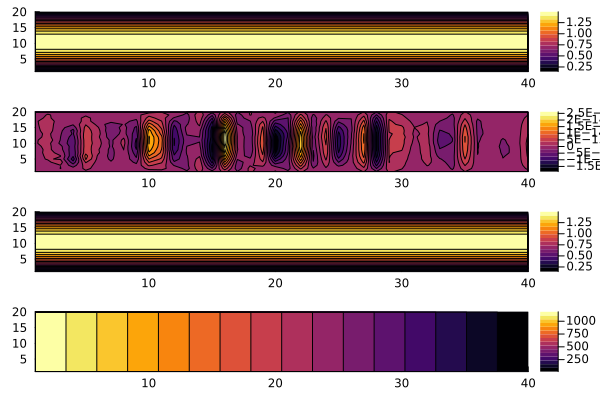

In [96]:
# Apply boundary conditions and solve
t_stationary = 2. 
update!(ch, t_stationary)
apply!(K, f, ch)
u = K \ f;

VTKGridFile("navier_stokes_channel", dh) do vtk
    write_solution(vtk, dh, u)
    Ferrite.write_constraints(vtk, ch)
end

# Post-processing 
area, velx2d, vely2d, velm2d, pres2d = mypostprocess(u, dh) 
p1 = contour(velx2d', fill=true)
p2 = contour(vely2d', fill=true)
p3 = contour(velm2d', fill=true)
p4 = contour(pres2d', fill=true)
plot(p1,p2,p3,p4,layout=(4,1))

#inlet_sampled = [parabolic_inflow_profile(Vec((0.,yi)),t_stationary)[1] for yi in ygrid]
#plot(ygrid,inlet_sampled, xlabel="x", ylabel="inlet velocity")

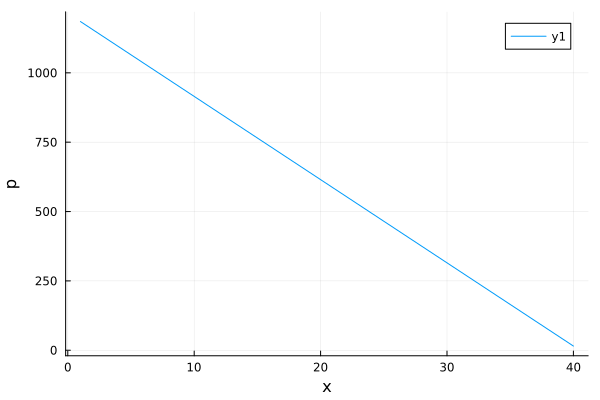

In [23]:
plot(pres2d[:,10],xlabel="x", ylabel="p")

In [24]:
pressure_drop = (8*vmax*viscosity*L)  / (H^2)

1199.9999999999998

## Section 7: Time-Integration Using DifferentialEquations.jl 

In [10]:
T = 6.0
Δt₀ = 0.001
Δt_save = 0.1

K = allocate_matrix(dh);
K = assemble_stokes_matrix(cellvalues_v, cellvalues_p, ν, K, dh);

M = allocate_matrix(dh);
M = assemble_mass_matrix(cellvalues_v, cellvalues_p, M, dh);

u₀ = zeros(ndofs(dh))
apply!(u₀, ch);

jac_sparsity = sparse(K);

apply!(M, ch)

struct RHSparams
    K::SparseMatrixCSC
    ch::ConstraintHandler
    dh::DofHandler
    cellvalues_v::CellValues
    u::Vector
end
p = RHSparams(K, ch, dh, cellvalues_v, copy(u₀))

function ferrite_limiter!(u, _, p, t)
    update!(p.ch, t)
    return apply!(u, p.ch)
end

function navierstokes_rhs_element!(dvₑ, vₑ, cellvalues_v)
    n_basefuncs = getnbasefunctions(cellvalues_v)
    for q_point in 1:getnquadpoints(cellvalues_v)
        dΩ = getdetJdV(cellvalues_v, q_point)
        ∇v = function_gradient(cellvalues_v, q_point, vₑ)
        v = function_value(cellvalues_v, q_point, vₑ)
        for j in 1:n_basefuncs
            φⱼ = shape_value(cellvalues_v, q_point, j)

            dvₑ[j] -= v ⋅ ∇v' ⋅ φⱼ * dΩ
        end
    end
    return
end

function stokes!(du, u_uc, p::RHSparams, t)

    @unpack K, ch, dh, cellvalues_v, u = p

    u .= u_uc
    update!(ch, t)
    apply!(u, ch)

    # Linear contribution (Stokes operator)
    mul!(du, K, u) # du .= K * u

    return
end;

function navierstokes!(du, u_uc, p::RHSparams, t)

    @unpack K, ch, dh, cellvalues_v, u = p

    u .= u_uc
    update!(ch, t)
    apply!(u, ch)

    # Linear contribution (Stokes operator)
    mul!(du, K, u) # du .= K * u

    # nonlinear contribution
    v_range = dof_range(dh, :v)
    n_basefuncs = getnbasefunctions(cellvalues_v)
    vₑ = zeros(n_basefuncs)
    duₑ = zeros(n_basefuncs)
    for cell in CellIterator(dh)
        Ferrite.reinit!(cellvalues_v, cell)
        v_celldofs = @view celldofs(cell)[v_range]
        vₑ .= @views u[v_celldofs]
        fill!(duₑ, 0.0)
        navierstokes_rhs_element!(duₑ, vₑ, cellvalues_v)
        assemble!(du, v_celldofs, duₑ)
    end
    return
end;

function navierstokes_jac_element!(Jₑ, vₑ, cellvalues_v)
    n_basefuncs = getnbasefunctions(cellvalues_v)
    for q_point in 1:getnquadpoints(cellvalues_v)
        dΩ = getdetJdV(cellvalues_v, q_point)
        ∇v = function_gradient(cellvalues_v, q_point, vₑ)
        v = function_value(cellvalues_v, q_point, vₑ)
        for j in 1:n_basefuncs
            φⱼ = shape_value(cellvalues_v, q_point, j)

            for i in 1:n_basefuncs
                φᵢ = shape_value(cellvalues_v, q_point, i)
                ∇φᵢ = shape_gradient(cellvalues_v, q_point, i)
                Jₑ[j, i] -= (φᵢ ⋅ ∇v' + v ⋅ ∇φᵢ') ⋅ φⱼ * dΩ
            end
        end
    end
    return
end

function stokes_jac!(J, u_uc, p, t)

    @unpack K, ch, dh, cellvalues_v, u = p

    u .= u_uc
    update!(ch, t)
    apply!(u, ch)

    # Linear contribution (Stokes operator)
    # Here we assume that J has exactly the same structure as K by construction
    nonzeros(J) .= nonzeros(K)

    assembler = start_assemble(J; fillzero = false)

    return apply!(J, ch)
end;

function navierstokes_jac!(J, u_uc, p, t)

    @unpack K, ch, dh, cellvalues_v, u = p

    u .= u_uc
    update!(ch, t)
    apply!(u, ch)

    # Linear contribution (Stokes operator)
    # Here we assume that J has exactly the same structure as K by construction
    nonzeros(J) .= nonzeros(K)

    assembler = start_assemble(J; fillzero = false)

    # Assemble variation of the nonlinear term
    n_basefuncs = getnbasefunctions(cellvalues_v)
    Jₑ = zeros(n_basefuncs, n_basefuncs)
    vₑ = zeros(n_basefuncs)
    v_range = dof_range(dh, :v)
    for cell in CellIterator(dh)
        Ferrite.reinit!(cellvalues_v, cell)
        v_celldofs = @view celldofs(cell)[v_range]

        vₑ .= @views u[v_celldofs]
        fill!(Jₑ, 0.0)
        navierstokes_jac_element!(Jₑ, vₑ, cellvalues_v)
        assemble!(assembler, v_celldofs, Jₑ)
    end

    return apply!(J, ch)
end;

st_rhs = ODEFunction(stokes!, mass_matrix=M; jac=navierstokes_jac!, jac_prototype=jac_sparsity)
st_problem = ODEProblem(st_rhs, u₀, (0.0,T), p);

ns_rhs = ODEFunction(navierstokes!, mass_matrix=M; jac=navierstokes_jac!, jac_prototype=jac_sparsity)
ns_problem = ODEProblem(ns_rhs, u₀, (0.0,T), p);

struct FreeDofErrorNorm
    ch::ConstraintHandler
end
(fe_norm::FreeDofErrorNorm)(u::Union{AbstractFloat, Complex}, t) = DiffEqBase.ODE_DEFAULT_NORM(u, t)
(fe_norm::FreeDofErrorNorm)(u::AbstractArray, t) = DiffEqBase.ODE_DEFAULT_NORM(u[fe_norm.ch.free_dofs], t)

timestepper = Rodas5P(autodiff=false, step_limiter! = ferrite_limiter!);

integrator = init(
    st_problem, timestepper; initializealg=NoInit(), dt=Δt₀,
    adaptive=true, abstol=1e-4, reltol=1e-5,
    progress=true, progress_steps=1,
    verbose=true, internalnorm=FreeDofErrorNorm(ch), d_discontinuities=[1.0]
);

pvd = paraview_collection("vortex-street")
for (step, (u,t)) in enumerate(intervals(integrator))
    VTKGridFile("vortex-street-$step", dh) do vtk
        write_solution(vtk, dh, u)
        pvd[t] = vtk
    end
end
vtk_save(pvd);

## Section 8: Solve Again, This Time Using the Solve Function `

In [31]:
st_sol = solve(
    st_problem, timestepper; initializealg=NoInit(), dt=Δt₀,
    adaptive=true, abstol=1e-4, reltol=1e-5,
    progress=true, progress_steps=1,
    verbose=true, internalnorm=FreeDofErrorNorm(ch), d_discontinuities=[1.0]
);

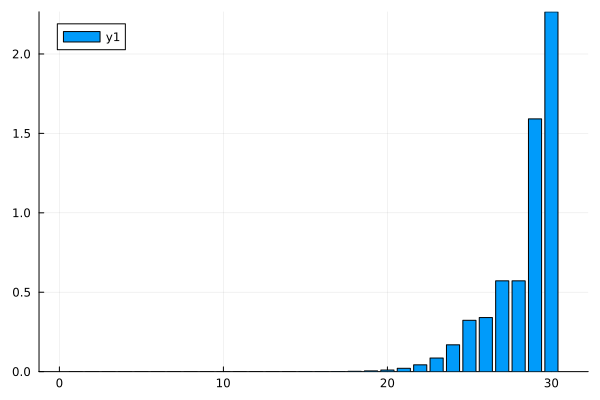

In [32]:
dt = st_sol.t[2:end] - st_sol.t[1:end-1]; 
bar(dt)

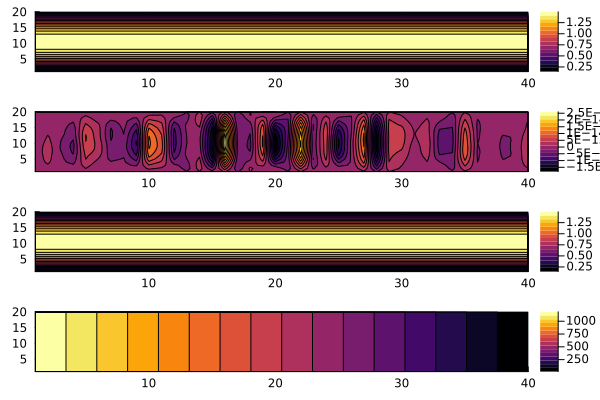

In [34]:
# post-process solution 
area, velx2d, vely2d, velm2d, pres2d = mypostprocess(st_sol.u[end], dh) 
p1 = contour(velx2d', fill=true)
p2 = contour(vely2d', fill=true)
p3 = contour(velm2d', fill=true)
p4 = contour(pres2d', fill=true)
plot(p1,p2,p3,p4,layout=(4,1))

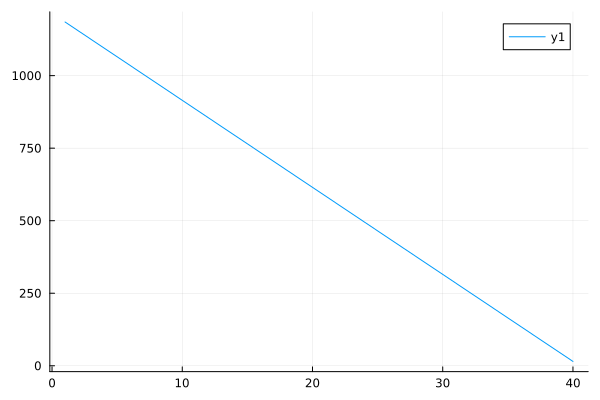

In [35]:
plot(pres2d[:,10])

## Section 9: Solve for Tracer (u1) in Post-Processing of the (Navier-)Stokes Solve  

In [41]:
function assemble_tracer_system!(K, dh_u1, cellvalues_u1, dh_up, cvu, pres_vel)
    assembler = start_assemble(K)
    range_u1  = dof_range(dh_u1, :u1)
    ndofs_u1  = length(range_u1)
    Ke = zeros(ndofs_u1, ndofs_u1)
    u1  = Vector{Float64}(undef, ndofs_u1)
    ∇u1 = Vector{Vec{2,Float64}}(undef, ndofs_u1)
    range_u = dof_range(dh_up, :v)
    
    for (cell_num, cell) in enumerate(CellIterator(dh_u1))

        fill!(Ke, 0)

        Ferrite.reinit!(cellvalues_u1, cell)

        vel_dof_loc = pres_vel[celldofs(dh_up,cell_num)[range_u]]
        
        for qp in 1:getnquadpoints(cellvalues_u1)
            dΩ = getdetJdV(cellvalues_u1, qp)
            for i in 1:ndofs_u1
                u1[i] = shape_value(cellvalues_u1, qp, i)
                ∇u1[i] = shape_gradient(cellvalues_u1, qp, i)
            end
            # u2-u2
            vel_loc = function_value(cvu, qp, vel_dof_loc) 
            # vel_loc[2] = 0 
            # vel_loc = [1,1]
            for (i, I) in pairs(range_u1), (j, J) in pairs(range_u1) 
                Ke[I, J] += ( ∇u1[i] ⋅ ∇u1[j] + (vel_loc ⋅ ∇u1[i] )* u1[j]) * dΩ
            end
        end 
            
        assemble!(assembler, celldofs(cell), Ke)
    end
    return K     
end

assemble_tracer_system! (generic function with 1 method)

In [79]:
function tracerpostprocess(u, dh, cellvalues_u1)
 
    area = [] 
    tracer = []

    for (cell_num, cell) in enumerate(CellIterator(dh))

        dof_range_tracer = dof_range(dh,:u1)
        u1loc = u[celldofs(dh,cell_num)[dof_range_tracer]]
        Ferrite.reinit!(cellvalues_u1, cell)

        cellarea = 0. 
        celltracer = 0. 
    
        for q_point in 1:getnquadpoints(cellvalues_u1)
            dΩ = getdetJdV(cellvalues_u1, q_point)
            tracer = function_value(cellvalues_u1, q_point, u1loc)
            cellarea += dΩ
            celltracer += celltracer*dΩ
        end

        append!(area, cellarea)
        display(celltracer)
        append!(tracer, celltracer/cellarea)
    
    end  

    tracer2d = reshape(tracer, nels)
    
    return area, tracer2d  
end 

tracerpostprocess (generic function with 1 method)

In [97]:
# Interpolations
degree = 1 
ipu1 = Lagrange{RefQuadrilateral,degree}()      # linear for tracer 

# FE values
qr = QuadratureRule{RefQuadrilateral}(2*degree+1)
ipg = Lagrange{RefQuadrilateral,1}() # linear geometric interpolation
cvu1 = CellValues(qr, ipu1, ipg) 

# Dof Handler for tracer (u1) 
dh_u1 = DofHandler(grid)
add!(dh_u1, :u1, ipu1)
close!(dh_u1)

# Constraint Handler for tracer (u1)
ch_u1 = ConstraintHandler(dh_u1)

u1_inlet = .5
dbc_u1 = Dirichlet(:u1, inlet, x -> u1_inlet)
add!(ch_u1, dbc_u1)

# Finalize
close!(ch_u1)

# Global tangent matrix and rhs for chemistry 
K_u1 = allocate_matrix(dh_u1, ch_u1)
f_u1 = zeros(ndofs(dh_u1));

u_up = st_sol.u[end]
assemble_tracer_system!(K_u1, dh_u1, cvu1, dh, cellvalues_v, u_up)

apply!(K_u1, f_u1, ch_u1)

u_u1 = (K_u1) \ f_u1; 

#area, tracer2d = tracerpostprocess(u_u1, dh_u1, cvu1)

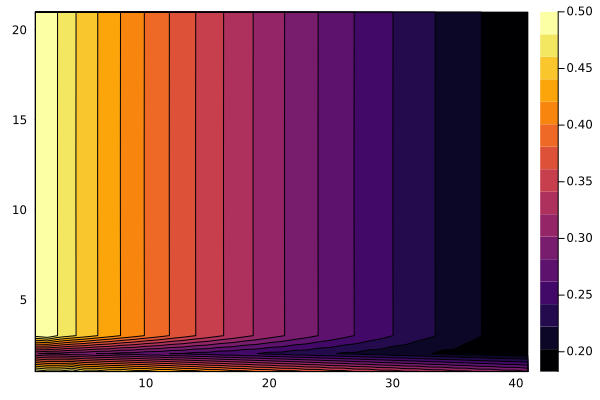

In [92]:
u2d = reshape(u_u1,nels[1]+1,nels[2]+1); 
contour(u2d', fill=true)